# Get relevant libraries

In [247]:
import ujson as json
import pprint
import pandas as pd
import numpy as np
import datetime
import time
import datetime
import calendar
import seaborn as sns
import matplotlib.dates as mdates

from matplotlib import pyplot as plt
from ggplot import *

# All plots should be inside notebook

In [248]:
%matplotlib inline
pd.options.mode.chained_assignment = None  # remove default='warn'

# Import data

In [249]:
filename = "/Users/fnokeke/dev/student-streams/dataset/LocationHistory.json"
with open(filename) as json_file:
    raw = json.load(json_file)

ld = pd.DataFrame(raw['locations'])
print("Number of items in data: %d") % len(ld)

# free up memory
del raw

Number of items in data: 266972


# Convert to typical units and rename columns

In [250]:
ld['latitudeE7'] = ld['latitudeE7']/float(1e7)
ld['longitudeE7'] = ld['longitudeE7']/float(1e7)
ld['timestampMs'] = ld['timestampMs'].map(lambda x: float(x)/1000)
ld['datetime'] = ld.timestampMs.map(datetime.datetime.fromtimestamp)

ld.rename(columns={
'latitudeE7': 'latitude',
'longitudeE7': 'longitude',
'timestampMs': 'timestamp'
}, inplace=True)

# Glimpse of raw data

In [251]:
print ld.dtypes
ld.head()

accuracy              int64
activitys            object
altitude            float64
heading             float64
latitude            float64
longitude           float64
timestamp           float64
velocity            float64
datetime     datetime64[ns]
dtype: object


,accuracy,activitys,altitude,heading,latitude,longitude,timestamp,velocity,datetime
0,20,"[{u'activities': [{u'confidence': 100, u'type'...",NaN,NaN,42.445009,-76.481233,1.444430e+09,NaN,2015-10-09 18:40:49.815
1,20,NaN,NaN,NaN,42.445002,-76.481257,1.444430e+09,NaN,2015-10-09 18:39:49.791
2,53,"[{u'activities': [{u'confidence': 100, u'type'...",NaN,NaN,42.445001,-76.481254,1.444430e+09,NaN,2015-10-09 18:38:48.981
3,51,"[{u'activities': [{u'confidence': 85, u'type':...",NaN,NaN,42.444977,-76.481236,1.444430e+09,NaN,2015-10-09 18:37:48.476
4,37,"[{u'activities': [{u'confidence': 100, u'type'...",NaN,NaN,42.444994,-76.481249,1.444430e+09,NaN,2015-10-09 18:36:59.451


# Ignore locations with accuracy estimates over 1000m

In [252]:
ld_wk = ld[ld.accuracy <= 1000]
print("No of rows left after drop: %d") % len(ld_wk)

No of rows left after drop: 252295


# Get only a specific number of weeks of data from specific start date

In [253]:
no_of_weeks = 10
start_date = "2014-11-09"

start_date = pd.to_datetime(start_date)
selected_dates = []
no_of_days = no_of_weeks * 7

# count 3 weeks back from start date
for i in range(no_of_days):
    x = start_date + datetime.timedelta(days=-i)
    x = x.strftime('%Y-%m-%d')
    selected_dates.append(x)
    
ld_wk['date'] = ld_wk.datetime.map(lambda x: x.strftime("%Y-%m-%d"))
ld_wk = ld_wk[ld_wk.date.isin(selected_dates)]
ld_wk = ld_wk[['latitude', 'longitude', 'datetime', 'date']]
print "%d week(s) of data: %d rows." % (no_of_weeks, len(ld_wk))
print "No of unique dates: %d." % len(set(selected_dates))

10 week(s) of data: 58016 rows.
No of unique dates: 70.


# Specify only places of interest in Ithaca and ignore locations outside Ithaca

In [254]:
HOME = (42.446594, -76.493736)
WORK = (42.444877, -76.480814)

lat_margin = 0.1
lon_margin = 1.0

# home location is used to estimate places outside Ithaca but 
# work location works just as well because the lat and lon margins 
# are definitely outside Ithaca
ld_wk = ld_wk[abs(ld_wk.latitude - HOME[0]) < lat_margin]
ld_wk = ld_wk[abs(ld_wk.longitude - WORK[1]) < lon_margin]

print "No of rows: %d." % len(ld_wk)
print "No of unique dates: %d." % len(set(ld_wk.date))

No of rows: 56720.
No of unique dates: 56.


# Label every location as either home, work or other

In [255]:
lat_error_margin = 0.0005
lon_error_margin = 0.005

POINTS = {
    'home': HOME,
    'work': WORK
}

def get_loc_label(df, points):
    for label, point in points.items():
        within_lat = abs(df['latitude'] - point[0]) <= lat_error_margin
        within_lon = abs(df['longitude'] - point[1]) <= lon_error_margin
        if (within_lat and within_lon):
            return label
    else:
        return 'other'

ld_wk['loc_label'] = ld_wk.apply(lambda x: get_loc_label(x, POINTS), axis='columns')
ld_wk.head()

,latitude,longitude,datetime,date,loc_label
106684,42.449137,-76.477510,2014-11-09 23:59:18.731,2014-11-09,other
106685,42.449135,-76.477484,2014-11-09 23:58:30.267,2014-11-09,other
106686,42.448740,-76.476888,2014-11-09 23:57:37.062,2014-11-09,other
106687,42.448755,-76.476863,2014-11-09 23:56:46.554,2014-11-09,other
106688,42.448761,-76.476850,2014-11-09 23:55:56.987,2014-11-09,other


# Mark every day by numeric value (0=Mon, 6=Sun)

In [256]:
weekday_patterns = ld_wk[['datetime', 'loc_label']]
weekday_patterns['day'] = weekday_patterns.datetime.map(lambda x: x.weekday())
weekday_patterns.head()

,datetime,loc_label,day
106684,2014-11-09 23:59:18.731,other,6
106685,2014-11-09 23:58:30.267,other,6
106686,2014-11-09 23:57:37.062,other,6
106687,2014-11-09 23:56:46.554,other,6
106688,2014-11-09 23:55:56.987,other,6


# Day of week by location frequency

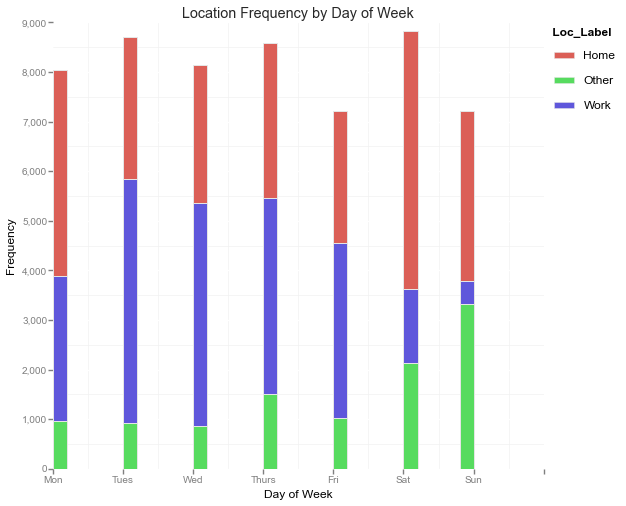

<ggplot: (364479665)>

In [257]:
weekday_label = ("Mon", "Tues", "Wed", "Thurs", "Fri", "Sat", "Sun")

ggplot(weekday_patterns, aes("day", fill='loc_label')) + geom_bar() + \
    scale_x_continuous(name="Day of Week", labels=weekday_label) + \
    scale_y_continuous(name="Frequency", labels="comma") + \
    ggtitle("Location Frequency by Day of Week") + \
    theme_bw()

# Trend for day of week by location frequency

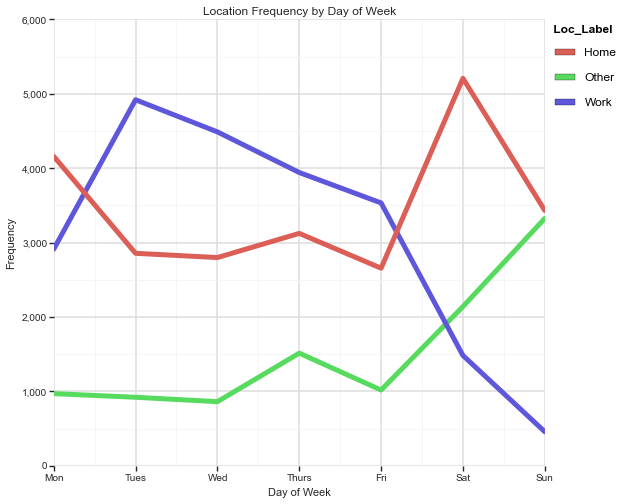

<ggplot: (364480273)>

In [258]:
wkdf = weekday_patterns[['day', 'loc_label']]
wkdf['freq'] = 0
wkdf = wkdf.groupby(['day', 'loc_label']).count().reset_index()

ggplot(wkdf, aes('day', 'freq', color='loc_label')) + geom_line(size=5) + \
    scale_x_continuous(name="Day of Week", labels=weekday_label) + \
    scale_y_continuous(name="Frequency", labels="comma") + \
    ggtitle("Location Frequency by Day of Week") + \
    theme_seaborn()

# Show location frequency by date (ggplot)

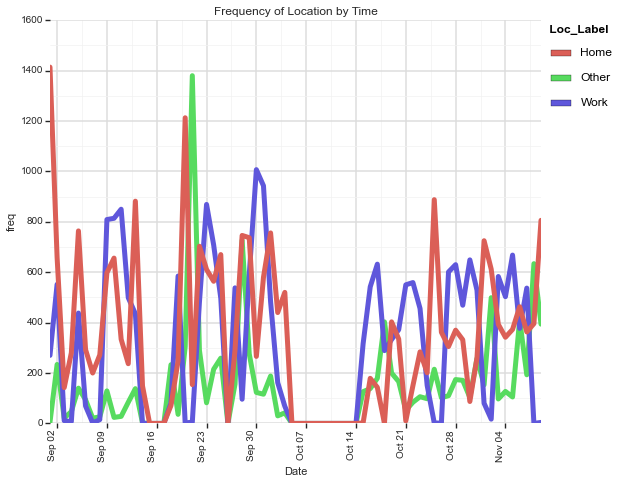

<ggplot: (338118381)>

In [259]:
date_df = weekday_patterns[['datetime', 'loc_label']]
date_df['freq'] = 0

date_df = date_df.set_index('datetime')
date_df = date_df.groupby('loc_label').resample('D', how='count').reset_index()

ggplot(date_df, aes('datetime', 'freq', color='loc_label')) + \
    geom_line(size=5) + \
    scale_x_date(name="Date", labels="%b %d", breaks=date_breaks("1 week")) + \
    ggtitle("Frequency of Location by Time") + \
    theme_seaborn() + \
    theme(axis_text_x  = element_text(angle = 90, hjust = 1))

# Day of week by time of day for each location

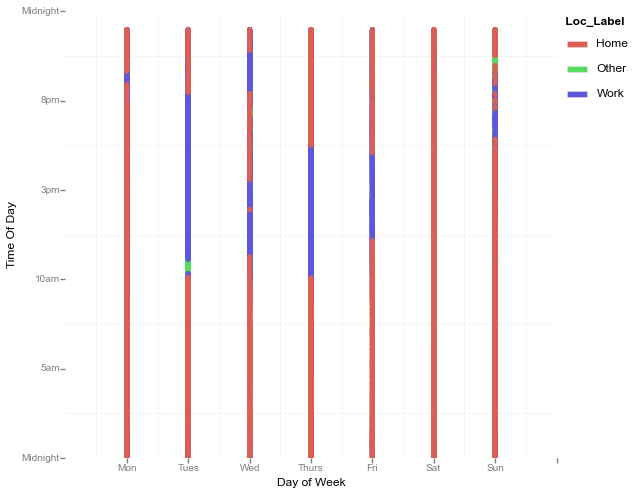

<ggplot: (338239209)>

In [260]:
day_patterns = ld_wk[['datetime', 'loc_label']]
day_patterns['day'] = day_patterns.datetime.map(lambda x: x.weekday())
day_patterns['time'] = day_patterns.datetime.map(lambda x: int(x.strftime("%H")) + float(x.strftime("%M"))/60)

weekday_label = ("Mon", "Tues", "Wed", "Thurs", "Fri", "Sat", "Sun")
time_label = ("Midnight", "5am", "10am", "3pm", "8pm", "Midnight")

ggplot(day_patterns, aes('day', 'time', color='loc_label')) + \
    geom_point() + \
    scale_x_continuous(name = "Day of Week", breaks=range(0,8), labels=weekday_label) + \
    scale_y_continuous(name="Time of Day", limits=(0,25), labels=time_label) + \
    theme_bw()

# Different dates by time and proportion of each location

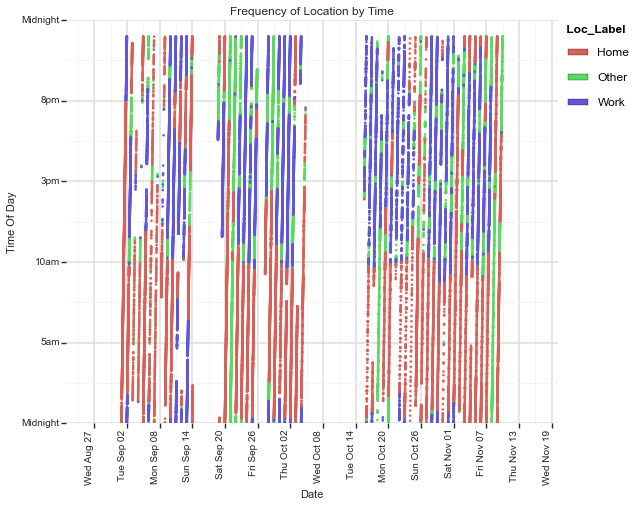

<ggplot: (374963549)>

In [261]:
time_label = ("Midnight", "5am", "10am", "3pm", "8pm", "Midnight")

date_df = weekday_patterns[['datetime', 'loc_label']]
date_df['time'] = date_df.datetime.map(lambda x: int(x.strftime("%H")) + float(x.strftime("%M"))/60)

ggplot(date_df, aes('datetime', 'time', color='loc_label')) + \
    geom_point(size=5) + \
    scale_x_date(name="Date", labels="%a %b %d", breaks=date_breaks("6 days")) + \
    scale_y_continuous(name="Time of Day", limits=(0,25), labels=time_label) + \
    ggtitle("Frequency of Location by Time") + \
    theme_seaborn() + \
    theme(axis_text_x=element_text(angle = 90, hjust = 1))